# Virtual Storage aggregation 

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
import matplotlib.axes as axes
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
import matplotlib.dates as mdates

In [17]:
from platform import python_version
print(python_version())

#3.7.12, version is only relevant for opening the input data pickles

3.7.12


## Data input 

In [18]:
# choose your settings 
short_or_long = "medium" #short: short, medium, long
flex = "constrained" #constrained meaning that late charging cannot be applied at public charging stations
initial_soc = 1
final_soc = 1
V2G = False #True does not work yet
soc_min = 0 #level that should preferably be reached as soon as possible after the EV is plugged in 

In [19]:
#path structure 
aggregation_path = os.getcwd()

#source path 
os.chdir(f"../")
source_path = os.getcwd()
os.chdir(aggregation_path)

data_path = os.path.join(source_path, "Input", short_or_long)

pics = os.path.join(source_path, "Output", "Pictures", f"{soc_min}", "V2G" if V2G else "G2V")
output = os.path.join(source_path, "Output", "Data", f"{soc_min}", "V2G" if V2G else "G2V")
os.makedirs(pics, exist_ok = True)
os.makedirs(output, exist_ok = True)

In [20]:
#emobpy import open this script in the aggregation folder
consumption_ts = pd.read_pickle(os.path.join(data_path, "consumption"))
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path,  "properties")) 

#for a short test
consumption_ts = consumption_ts.iloc[:400,0:200]
availability_ts = availability_ts.iloc[:400,0:20]
car_properties_raw = car_properties_raw.iloc[:400,0:20]

#ensuring to have the same order of cars in all dataframes
profiles = min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])
time_steps = len(availability_ts.dropna().index) #if infeasible consumption profiles where created, this would cause the infeasabiltiy in the availability profile

In [21]:
car_properties_raw.iloc[0] = initial_soc
car_properties_raw.iloc[1] = final_soc

In [22]:
car_properties_raw.loc["battery_capacity"].mean() #average battery capacity of the fleet

54.032500000000006

In [23]:
#resample to kWh / h
consumption_raw, power_raw, car_properties_raw = consumption_ts.iloc[:time_steps, :profiles].resample("h").mean(), availability_ts.iloc[:time_steps, :profiles].resample("h").mean(), car_properties_raw.iloc[:, :profiles]

In [24]:
#ensuring that resampling did not cause any NaNs
time_steps = len(power_raw.dropna().index)
consumption_raw, power_raw, car_properties_raw = consumption_raw.iloc[:time_steps, :profiles].dropna(), power_raw.iloc[:time_steps, :profiles].dropna(), car_properties_raw.iloc[:,:profiles].dropna()
neg_power_magnitude_raw = power_raw

In [25]:
#set datetime indexes 
index = consumption_raw.index
consumption_raw.index, power_raw.index, neg_power_magnitude_raw.index = index, index, index

step_duration = 1 #h
print(pd.infer_freq(index))


H


## Data plausibility

In [26]:
scale = 15/consumption_raw.shape[1] #assumption: 15 mio EVs. Factor to scale fleet values [kWh] to the scaled fleet values in [GWh]

In [27]:
#i = 50
#random_number = random.randint(0, profiles-i)
#l = [consumption_raw.iloc[:50, random_number:random_number+10].sum(1)/10,  consumption_raw.iloc[:50, random_number:random_number+i].sum(1)/i]
#df = pd.concat(l, axis =1, keys=["10 profiles", f"{i} profiles"])

#df.plot(ylim=(0), ylabel="consumption [kW/EV]")

In [28]:
#consumption_raw.mean(1).resample("h").mean().resample("D").sum().plot()
#consumption_raw.resample("h").mean().resample("D").sum().mean(1).resample("w").mean().plot()

In [29]:
week_list = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def groupby_weekday(df):
    return df.groupby(df.index.day_name()).sum().reindex(week_list) 

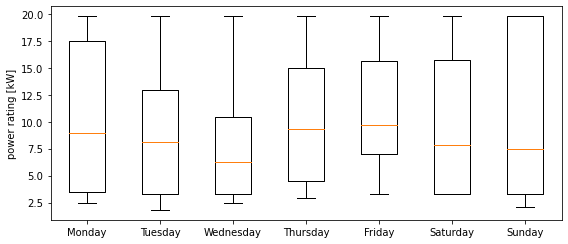

In [30]:
#power ratings are mostly between 3 and 20 kW 
if soc_min ==0:  
    ts = power_raw.loc[(index.day<=7) & (index.month==1)].resample("D").mean()
    ts = ts.groupby(ts.index.day_name()).sum().reindex(week_list) 
    
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.boxplot(
        ts.transpose(), labels= ts.index,
          )

    plt.ylabel('power rating [kW]')

    fig.tight_layout()
    #plt.savefig(os.path.join(pics, 'average_power_rating.png'), bbox_inches = "tight")

(0.0, 2.38610197368421)

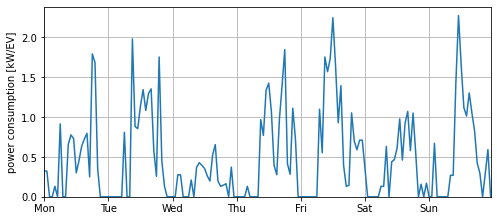

In [31]:

ts =  (consumption_raw.mean(1)).resample("H").sum()
ts = ts[(ts.index.day >5)&(ts.index.day <13) & (ts.index.month ==1)]


fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(ts.index, ts)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

ax.set_ylabel("power consumption [kW/EV]")
ax.grid('on', which='minor', axis='x', alpha=0.3)
ax.grid('on', which='major' )
ax.set_xlim(ts.index[0],ts.index[-1])
ax.set_ylim(0)

#plt.savefig(f"{pics}/consumtion_power_availability.png", bbox_inches = "tight")

In [32]:
print(np.unique(power_raw.values) )

station_dict = {0.0 : "none",
                1.665 : "home_low",
               3.33 : "home_high",
               9.9 : "work",
               19.8: "public"}
color_dict = {0.0 : "orange",
              1.665 : "green",
               3.33 : "green",
                9.9 : "red",
               19.8: "#0000FF"}


rating_weighted = False

p = power_raw
t = p.resample("H").ffill()
ts = t
ts = ts[(ts.index.day >5)&(ts.index.day <13) & (ts.index.month ==1)]

[ 0.     1.665  3.33   9.9   19.8  ]


Text(0.5, 0, 'January, 2020')

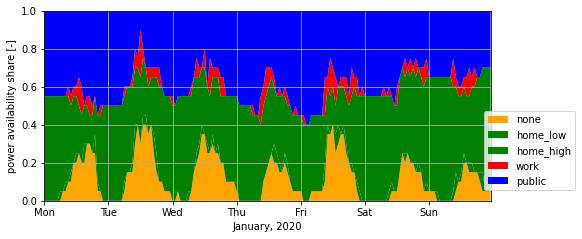

In [33]:

fig, ax = plt.subplots(figsize=(8, 3.5))
i = 0
bottom = 0
if rating_weighted == True: 
    n = ts[ts==3.33].count(1)*3.33 + ts[ts==19.8].count(1)*19.8

for r in np.unique(ts.values):
    if rating_weighted == True: 
        next_bottom = bottom+ts[ts==r].count(1)*r /n

    else: 
        next_bottom = bottom+ts[ts==r].count(1) / ts.shape[1]

    if (rating_weighted == True) &(r==0):
        continue
    else:
        plt.fill_between(x = ts.index,
            y1 = bottom,
            y2 = next_bottom,
            #alpha = 0.5,
            label = station_dict[r],
            facecolor = color_dict[r])
    bottom = next_bottom
    
    

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.ylabel("power availability share [-]")
plt.ylim(0,1)
plt.xlim(ts.index[0],ts.index[-1])
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))
plt.grid()
ax.set_xlabel("January, 2020")
#plt.savefig(f"{pics}/availability_shares_weighted_{str(rating_weighted)}",bbox_inches = "tight" )

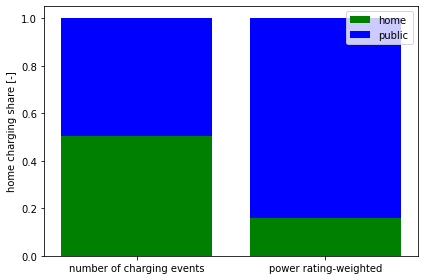

In [34]:

home_share_events = power_raw[power_raw==3.33].count().sum() / power_raw[power_raw>0].count().sum()
home_share_rating = power_raw[power_raw==3.33].sum().sum() / power_raw.sum().sum()


plt.bar(
    ["number of charging events", "power rating-weighted"], [home_share_events, home_share_rating]
     , label = "home", color = "green")
plt.bar(
    ["number of charging events", "power rating-weighted"], [1-home_share_events, 1-home_share_rating]
       , bottom = [home_share_events, home_share_rating], label = "public", color = "#0000FF")
plt.ylabel("home charging share [-]")
plt.legend()
plt.tight_layout()

#plt.savefig(f'{pics}/home_charging_shares.png',bbox_inches = "tight")

In [35]:
#https://www.agora-energiewende.de/en/service/recent-electricity-data/chart/power_generation/08.08.2021/08.08.2022/today/
german_peak = 73.3 #GW 30.11.2021
peak_load = (consumption_raw.sum(1).nlargest(1).sum())*scale #kW
print(peak_load) #kW 
print(peak_load / german_peak) #kW --> GW

39.06578947368421
0.532957564443168


# Virtual storage transformation: Generating uncontrolled and latest charging ts

In [36]:
#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [37]:
solution_dict = {}
ees_constraints= pd.DataFrame()
M = 100000 #for big M method
failed_profiles = []

count = 0
count_failed = 0
for car in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[car].columns
    except AttributeError as a:
        car_list = [car]

    for i, c in enumerate(car_list):
        print(count)
        if type(consumption_raw[c]) == pd.core.series.Series:
            consumption = consumption_raw[c]
            power = power_raw[car]
            neg_power_magnitude = neg_power_magnitude_raw[c]
            car_properties = car_properties_raw[c]

        else: 
            consumption = consumption_raw[c].iloc[:,i]
            power= power_raw[car].iloc[:,i]
            neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
            car_properties= car_properties_raw[c].iloc[:,i]

        
        battery_capacity = car_properties.loc["battery_capacity"]
        level_0 = car_properties["soc_init"]*battery_capacity
        level_T = car_properties.loc["soc_end"]*battery_capacity

        for model_type in ["m_early", "m_late"]:
            if (model_type == "m_late") & (car+str(i) in failed_profiles): 
                pass
            else:
                #Initialize model
                m = pyo.ConcreteModel()

                #initialize sets
                m.t = pyo.Set(initialize = index, ordered = True)

                #Initialize parameter
                m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
                m.power = pyo.Param(m.t, initialize=power.to_dict()) 
                m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

                #Initialize variables
                m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.SLACK = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.SLACK_2 = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                                    bounds = (0,battery_capacity))

                if model_type == "m_late":

                    public_index = power[(power>12)].index
                    print(power[public_index].unique())
                    dep_home_index = consumption[((consumption==0) & (consumption.shift(-1) > 0) == True)].index

                    m.t_pub = pyo.Set(initialize = public_index, ordered = True)
                    m.t_dep_home = pyo.Set(initialize = dep_home_index, ordered = True)

                    def public_uncontrolled(m, t_pub):
                        return m.CHARGE[t_pub] + m.SLACK_2[t_pub] >= m.power[t_pub]
                    m.Public_uncontrolled = pyo.Constraint(m.t_pub, rule=public_uncontrolled)

                    def full_before_next_trip(m, t_dep): 
                        if t_dep in  index[:2]:
                            return pyo.Constraint.Skip
                        else:
                            t_dep_1 = pd.Timestamp(t_dep) - pd.Timedelta(f'{step_duration} H')
                            return m.LEVEL[t_dep_1] >= solution_dict[car+str(i)]["m_early"]["level"].loc[t_dep_1]
                    m.Full_before_next_trip = pyo.Constraint(m.t_dep_home, rule=full_before_next_trip)

                #level constraints
                def recursive_level(m, t):
                    if t == index[0]:
                        return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )
                    else:    
                        return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                            pd.Timedelta(f'{step_duration} H')] + (
                            m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )   
                m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

                def final_level(m, t):
                    if t == index[-1]:
                        return m.LEVEL[t] == level_T
                    else: 
                        return pyo.Constraint.Skip
                m.Final_level = pyo.Constraint(m.t, rule=final_level)

                #bidirectional charging 
                def neg_power_min(m, t):
                    if V2G == True:
                        return m.DISCHARGE[t] <= m.neg_power[t] 
                    else:
                        return m.DISCHARGE[t] ==0
                m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

                def power_max(m, t):
                    return m.CHARGE[t] <= m.power[t]   
                m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)

                def avoid_min_level(m, t):
                    return m.LEVEL[t] + m.SLACK[t] >= battery_capacity*soc_min
                m.Avoid_min_level = pyo.Constraint(m.t, rule=avoid_min_level)

                def battery_level_sum(m, t):    
                    if model_type == "m_late":
                        return sum(m.LEVEL[t] + M * m.SLACK[t] + M * m.SLACK_2[t] for t in m.t) 
                    else:
                        return sum(m.LEVEL[t] for t in m.t) 
                if model_type == "m_late": sense = pyo.minimize
                else: sense = pyo.maximize


                m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

                #find solver
                solvername='glpk'

                #prepare solver
                optimizer = opt.SolverFactory(solvername) 
                solved_model = optimizer.solve(m)      ##tee=True   

                if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                    failed_profiles.append(car+str(i))
                    print("failed")
                    count_failed += 1
                else:    
                    print("succeeded")
                    level_series = pd.concat([
                        pd.Series(0, index=[index[0]-pd.Timedelta(index.freq)]),
                        pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                    ], axis=0)
                    charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                    discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
                    
    
                    #store data in dictionary
                    if model_type == "m_early":
                        solution_dict[car+str(i)] = {}
                    solution_dict[car+str(i)][model_type] = {}
                    solution_dict[car+str(i)][model_type]["level"] = level_series
                    solution_dict[car+str(i)][model_type]["charge"] = charge_df
                    solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
                    if model_type == "m_late":
                        count += 1 
solution_dict["failed_profiles"] = failed_profiles

0
failed
0
failed
0
failed
0
failed
0
succeeded
[19.8]
succeeded
1
succeeded
[19.8]
succeeded
2
succeeded
[19.8]
succeeded
3
succeeded
[19.8]
succeeded
4
succeeded
[19.8]
succeeded
5
succeeded
[19.8]
succeeded
6
succeeded
[19.8]
succeeded
7
succeeded
[19.8]
succeeded
8
succeeded
[19.8]
succeeded
9
failed
9
failed
9
failed
9
succeeded
[19.8]
succeeded
10
succeeded
[19.8]
succeeded
11
succeeded
[19.8]
succeeded
12
failed


In [38]:
level_index = solution_dict[list(solution_dict.keys())[0]][model_type]["level"].index #if index error, check if all cars have the same initial and final index element

In [39]:
file =  f'{output}/solution_dict.pickle'
#with open(file, 'wb') as handle:
#    pickle.dump(solution_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(file, 'rb') as handle:
#    solution_dict = pickle.load(handle)
    
    
    
    

##  Processing the virtual storage-profiles

In [40]:
#Aggregation: extract differences between early and late charging profiles
uncontrolled_level_accurate, uncontrolled_charge_df, early, late = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame()
df_con, df_pow, df_neg_pow, df_pro =  pd.DataFrame(), pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

count = 0
keys = list(solution_dict.keys())
for c in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[c].columns
    except AttributeError as a:
        car_list = [c]
        
    for i, car in enumerate(car_list):
        if car+str(i) in keys:
            try: 
                
                early = pd.concat([
                    early, solution_dict[car+str(i)]["m_early"]["level"]
                ], axis=1).sum(1)
                late = pd.concat([
                   late, solution_dict[car+str(i)]["m_late"]["level"]
                ], axis=1).sum(1)
                uncontrolled_charge_df = pd.concat([
                    uncontrolled_charge_df, solution_dict[car+str(i)]["m_early"]["charge"]
                ], axis=1)
            

                if type(consumption_raw[car]) == pd.core.series.Series: 
                    df_con[car] = consumption_raw[car]
                    df_pow[car] = power_raw[car]
                    df_neg_pow[car] = neg_power_magnitude_raw[car]
                    df_pro[car] = car_properties_raw[car]
                else: 
                    df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
                    df_pow[car+str(i)] = power_raw[car].iloc[:,i]
                    df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
                    df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
                print(count)  
                count +=1
            except KeyError: 
                print(car+str(i))
                pass

0
1
2
3
4
5
6
7
8


9
10
11


In [41]:
# to pickle

#df_con.to_pickle(f"{output}/df_con")
#df_pow.to_pickle(f"{output}(df_pow")
#df_neg_pow.to_pickle(f"{output}/df_neg_pow")
#df_pro.to_pickle(f"{output}/df_pro")

#uncontrolled_charge_df.to_pickle(f"{output}/uncontrolled")
#early.to_pickle(f"{output}/early")
#late.to_pickle(f"{output}/late")

# Aggregation

In [61]:
#from pickle new structure
df_con = pd.read_pickle(f"{output}/df_con")
df_pow = pd.read_pickle(f"{output}/df_pow")
df_neg_pow = pd.read_pickle(f"{output}/df_neg_pow")
df_pro = pd.read_pickle(f"{output}/df_pro")
uncontrolled_charge_df = pd.read_pickle(f"{output}/uncontrolled")
early = pd.read_pickle(f"{output}/early")
late = pd.read_pickle(f"{output}/late")

In [62]:
#set number of profiles manually or automatically
profiles = 100#df_con.shape[1] 
time_steps = 100#df_con.shape[0]

#adjust dfs according to profiles and time steps
##ensure no NaNs and that inital and final level are set correctly
df_con, df_pow, df_neg_pow, uncontrolled_charge_df = df_con.dropna().resample("1h").mean().iloc[:time_steps, :profiles], df_pow.dropna().resample("1h").mean().iloc[:time_steps, :profiles], df_neg_pow.dropna().resample("1h").mean().iloc[:time_steps, :profiles], uncontrolled_charge_df.dropna().resample("1h").mean().iloc[:time_steps, :profiles]
early, late = early.dropna().resample("1h").mean().iloc[:time_steps + 1], late.dropna().resample("1h").mean().iloc[:time_steps + 1]
df_pro = df_pro.dropna().iloc[:profiles]
#df_pow.resample("1h").mean(), df_neg_pow.resample("1h").mean(), early.resample("1h").mean(), late.resample("1h").mean(), uncontrolled_charge_df.resample("1h").mean()


profiles, time_steps = df_con.shape[1], df_con.shape[0] 

In [63]:
#number of profiles and time steps and scaling factor for fleet of 15 mio EVs [assumption]
scale = 15/profiles #sampled fleet in kW --> 15 mio EVs in GW
scale_down = 1/profiles #sampled fleet in kW --> per EV in kW/EV

In [64]:
#index declaration
index, profiles = df_con.index , df_con.shape[1]
level_index  = late.index


#aggregated initial and final level
level_0_agg = sum(df_pro.loc["soc_init"]*df_pro.loc["battery_capacity"])
level_T_agg = sum(df_pro.loc["soc_end"]*df_pro.loc["battery_capacity"])  

#aggregation of energy constraints
uncontrolled_level_accurate = early
uncontrolled_level_accurate.iloc[0] = level_0_agg 
uncontrolled_level_accurate.name = "uncontrolled_level"

ees_constraints_aggergated = late-early
uncontrolled_charge_accurate = uncontrolled_charge_df.sum(1)

In [65]:
#aggregation of power constraints
#addind the additional initial time step with value 0 to all power timeseries as the energy level is described recursively and needs (t_0 - 1) to define t_0
aggregated_max_battery = df_pro.loc["battery_capacity"][ :profiles].sum()

consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(index.freq)]), df_con.sum(1)
              ], axis = 0)
consumption_aggregated.name = "consumption"

power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(index.freq)]), df_pow.sum(1)
              ], axis = 0)

neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(index.freq)]), df_neg_pow.sum(1)
              ], axis = 0)

#aggregation
naive_constraints_aggergated = pd.Series(data=sum(
    df_pro.loc["battery_capacity"][ :profiles]), index=level_index) #all battery capicities

In [66]:
#model shares in aggreagted fleet
models = df_pro.columns.str[:10].unique()
m_l = []
for element in models:
    m_l.append(element.split("/")[0])
shares = pd.DataFrame(index=m_l, columns=["shares"])
for m in models:
    shares.loc[m.split("/")[0]] = df_pro.columns.str.contains(m).sum()
n = shares.sum()
shares = shares/n*100

print(shares)

               shares
Tesla       31.494325
Renault     22.367591
Volkswagen  26.387137
FIAT          5.54855
Hyundai      6.210593
Audi         1.592055
KIA          0.961538
BMW          2.616646
MINI         2.821564


## Representative fleet size calculation

In [67]:
os.makedirs(f"{output}/tmp", exist_ok = True)

overall_peak = early.max()
overall_consumption_avg = early.mean()

tmp_peak, tmp_cons = pd.DataFrame(),  pd.DataFrame()
fleet_size = profiles

count = 0
while count < 12:
    print(count)
    increasing_df = pd.DataFrame(index=range(0, fleet_size), columns=["peak_load", "avg_consumption"])
    ordered_df = uncontrolled_charge_df.sample(frac=1, axis=1)
    for n, i in enumerate(ordered_df.columns):
        
        df = ordered_df.iloc[:, :n]
        sub_peak = df.sum(1).max()
        sub_consumption = df.sum(1).mean()
        scaled_peak = sub_peak * fleet_size / (n+1)
        scaled_consumption = sub_consumption * fleet_size / (n+1)
        increasing_df.iloc[n] = [scaled_peak, scaled_consumption]
    
    tmp_peak[count], tmp_cons[count] = increasing_df["peak_load"], increasing_df["avg_consumption"]
    count += 1

tmp_peak.to_pickle(f"{output}/tmp/peak_1")
tmp_cons.to_pickle(f"{output}/tmp/cons_1")

0
1
2
3
4
5
6
7
8
9
10
11


In [68]:
#get different power ratings for each car and charging session
t = np.unique(uncontrolled_charge_df[uncontrolled_charge_df>0])
df = pd.DataFrame(t)

df_ = df.copy()
df["home"] = df_[df_<=3.33]
df["public"] =  df_[df_>3.33]
df=df[["home", "public"]]

sampled = pd.concat([
    pd.concat([tmp_peak.std(1), tmp_peak.mean(1)],axis = 1, keys = ["std_deviation", "mean"]), 
    pd.concat([tmp_cons.std(1), tmp_cons.mean(1)],axis = 1, keys = ["std_deviation", "mean"])
    ], axis = 1, keys = ["peak", "consumption"]).iloc[10:]

sampled.to_pickle("results/sampled_1")


p_list=[pd.read_pickle(f"results/{p}") for p in ["sampled", "sampled_1", "sampled_3"]]
df = pd.concat(p_list, axis=1)
columns = pd.MultiIndex.from_tuples([
    ("peak", "mean"), ("peak", "std_deviation"), ("consumption", "mean"), ("consumption","std_deviation")
])
sampled = pd.DataFrame(columns=columns, index=df.index)
sampled.loc[:,("peak", "std_deviation")], sampled.loc[:,("peak","mean")]  = df["peak"]["std_deviation"].max(1), df["peak"]["mean"].mean(1)
sampled.loc[:,("consumption", "std_deviation")], sampled.loc[:,("consumption", "mean")]  = df["consumption"]["std_deviation"].max(1), df["consumption"]["mean"].mean(1)

In [69]:
from os import listdir
from os.path import isfile, join

files = [f for f in listdir(f"{output}/tmp") if isfile(join(f"{output}/tmp", f))]
p_files, c_files  = [f for f in files if "peak" in f], [f for f in files if "cons" in f]
p_list = [pd.read_pickle(f"{output}/tmp/{f}") for f in p_files]
c_list = [pd.read_pickle(f"{output}/tmp/{f}") for f in c_files]

tmp_peak, tmp_cons = pd.concat(p_list, axis=1), pd.concat(c_list, axis=1)

sampled = pd.concat(
    [        pd.concat(
        [tmp_peak.std(1), tmp_peak.mean(1)],
        axis = 1, keys = ["std_deviation", "mean"]
        ), pd.concat(
        [tmp_cons.std(1), tmp_cons.mean(1)],
        axis = 1, keys = ["std_deviation", "mean"]
        )
    ], axis = 1, keys = ["peak", "consumption"]).iloc[10:].loc[:12000]


s = 15/sampled.shape[0]
s_down = 1 / sampled.shape[0]

In [70]:
iterations = tmp_peak.shape[1]
iterations

12

In [71]:
for i in range(0,10):
    df = uncontrolled_charge_df.sample(frac=1, axis=1).iloc[:,1]
    print(df.max()) #peak loads

19.8
19.8
14.2105263157895
19.8
11.0526315789474
15.7894736842105
3.33000000000001
19.8
11.0526315789474
5.0


In [72]:
def area_plot(df, peak_or_consumption=True):
    
    df_fleet=df*s  #15mio EVs in GW 
    df_single = df*s_down
    
    fig, ax = plt.subplots(figsize=(8, 3.5))
   
    ax.fill_between(
        df_single.index, df_single["mean"]+df_single["std_deviation"], df_single["mean"]-df_single["std_deviation"], alpha=0.5, label="standard deviation"
    ) 
    
    p = df_single["mean"].plot() 
    
    ax2=p.twinx()
    ax2.spines['right'].set_position(('axes',  1))
    
    ax.set_xlabel("Sampling size")
    ax.set_ylabel("Peak load [kW/EV]") 
    ax2.set_ylabel("Peak load [GW]") 
    ax.set_xlim(0)
    
    ax.grid('on', which='minor' , alpha=0.3)
    ax.grid('on', which='major' )

    for i in [0, 1]:
        if i == 0: 
            max_val = round(df_single["mean"].iloc[100], 1)
            min_val = round(df_single["mean"].iloc[-1], 1)
            step_size = round((max_val-min_val)/5, 1)
            
            ax.set_ylim(min_val, max_val+step_size/5)
            ax.set_yticks(np.arange(min_val,max_val+step_size, step_size))
        else:
            max_val = round(df_fleet["mean"].iloc[100], 0)
            min_val = round(df_fleet["mean"].iloc[-1], 0)
            step_size = round((max_val-min_val)/5, 0)
            
            ax2.set_ylim(min_val, max_val+step_size/5)
            ax2.set_yticks(np.arange(min_val,max_val+step_size, step_size))
    ax.legend()
    plt.show()

IndexError: single positional indexer is out-of-bounds

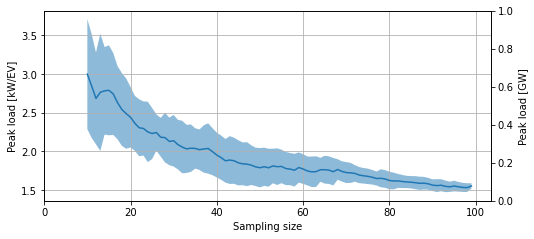

In [73]:
area_plot(sampled["peak"])
#plt.savefig("ADMD.png" , dpi=1200)

In [55]:
peak_per_EV = (sampled["peak"]["mean"].iloc[-1]*s_down)

<AxesSubplot:ylabel='kWh/day/EV'>

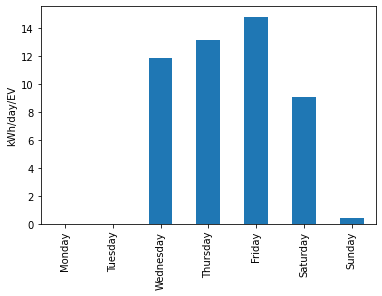

In [56]:
week_list = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def groupby_weekday(df):
    return df.groupby(df.index.day_name()).mean().reindex(week_list) 

df = uncontrolled_charge_df#df_con
bars = df[(df.index.month==1)&(df.index.day<8)].resample("h").mean().resample("D").sum().mean(1)

groupby_weekday(bars).plot.bar(ylabel = "kWh/day/EV")

In [57]:
def area_plot(df, peak_or_consumption=True):
    df_ev = df * scale_down
    df = df*s
    
    plt.fill_between(
        df.index, df["mean"]+df["std_deviation"], df["mean"]-df["std_deviation"], alpha=0.5, label="standard deviation"
    ) 
    plt.plot(df.index, df["mean"], label="mean")
    
    ax2 = plt.twinx()
    ax2.spines['right'].set_position(('axes',  1))

    #ax2 = df_ev["mean"].plot(alpha=0, ylabel="%")

    
    plt.xlabel("sampling size")
    plt.ylabel("GW")
    plt.ylim(df["mean"].iloc[-1]*0.9, df["mean"].iloc[200])
    plt.title(
        ("peak" if peak_or_consumption else "average") + " load " + ("for 15 mio EVs & per average EV")
    )
    plt.legend()

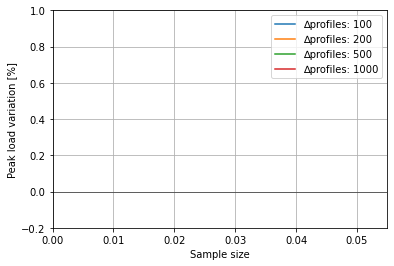

In [58]:
n_l = [100, 200, 500, 1000]
for n in n_l:
    df = sampled["peak"]["mean"]
    df_diff_rel = df.diff(-n)/df*100
    ax = df_diff_rel.plot(ylim=(-0.2,1), xlabel= "Sample size", ylabel="Peak load variation [%]", xlim=(0), label=f'∆profiles: {n}')
    ax.grid()
plt.axhline(color="black", linewidth=0.5)
plt.legend()    
#plt.savefig("ADMD_change.png", dpi=1200)

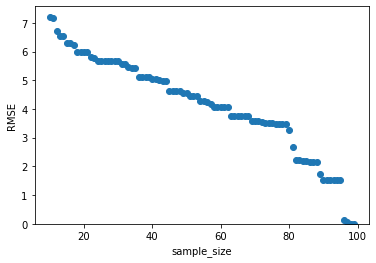

In [59]:
#install sklearn
#!pip install -U scikit-learn
from sklearn.metrics import mean_squared_error

reduced = uncontrolled_charge_df
n_max = uncontrolled_charge_df.shape[1]
rmse = {}

for sample_size in range(10, n_max): 
    Y_true = reduced.max(1)
    Y_pred = reduced.iloc[:,:sample_size].max(1)
    rmse[f'{sample_size}'] = mean_squared_error(Y_true,Y_pred, squared=False) 
    
plt.scatter(range(10, n_max), rmse.values())
plt.xlabel("sample_size")
plt.ylabel("RMSE")
plt.ylim(0)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

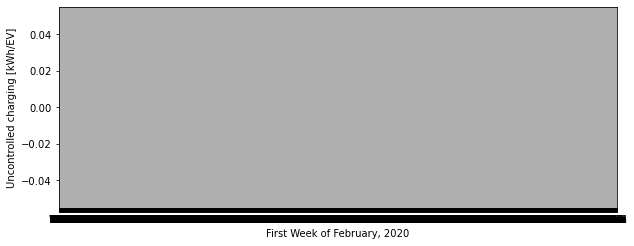

In [60]:
df = uncontrolled_charge_df
condition = ((df.index.month==2 )&(df.index.day>2)&(df.index.day<10))
ts_1 = df[condition].iloc[:, :10000].mean(1)
ts_2 = df[condition].iloc[:, :1000].mean(1)
ts_3 = df[condition].iloc[:, 100:200].mean(1)

df_all = pd.concat([ts_1, ts_2, ts_3], axis=1, keys=["10000 profiles", "1000 profiles", "100 profiles"])


fig, ax = plt.subplots(figsize=(10, 3.7))
ax.plot(df_all.index, df_all)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

ax.set_ylabel("Uncontrolled charging [kWh/EV]")
ax.set_xlabel("March, 2020")
ax.grid('on', which='minor', axis='x', alpha=0.3)
ax.grid('on', which='major' )
ax.set_xlabel("First Week of February, 2020")
ax.set_xlim(df_all.index[0],df_all.index[-1])
ax.set_ylim(0,1.4)
ax.legend(list(df_all.columns), bbox_to_anchor=(1.003,1.01))
fig.tight_layout()

#plt.savefig("uncontrolled.pdf", dpi=1200, bbox_inches = "tight")

# Comparison virutal storage vs naive aggreagtion

df = pd.concat([
    -ees_constraints_aggergated, pd.Series(aggregated_max_battery,level_index)
], axis = 1, keys = ["ees", "aggregated_batteries"]).resample("2h").mean()*scale
t = df.index
df_2 = pd.Series(100, t)

ax = df.plot(ylabel="GWh", label = 'level_values')

ax.legend(bbox_to_anchor=(1.05,0.2))

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ax2 = df_2.plot(alpha=0, ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)

n = round(df["ees"].max())
ax.axhline(n, color="black", alpha = 1, linewidth=0.8)
ax.text(y=n+20,x=t[-100], s=f"< {n} GWh,  {round(n/df.max().max(), 2)*100}%")

ax.grid('on', which='minor', axis='x' , alpha = 0.3)
ax.grid('on', which='major' )

max_val = 10 - int(df["aggregated_batteries"].max()) % 10 + int(df["aggregated_batteries"].max())

for i, s in enumerate([df, df_2]):
    if i == 0: 
        step_size = (max_val)/5 
        ax.set_ylim(0, max_val+step_size/5)
        ax.set_yticks(np.arange(0,max_val+1, step_size))
    else:
        step_size = 100/5
        ax2.set_ylim(0, 100 +step_size/5)
        ax2.set_yticks(np.arange(0,101, step_size))

#plt.savefig(os.path.join(pics, 'level_comparison_size_ts.png'), bbox_inches = "tight")
##

condition_1 = ((uncontrolled_level_accurate.index.month ==2) & (uncontrolled_level_accurate.index.day >2) & (uncontrolled_level_accurate.index.day <=9) )
condition_2 = ((uncontrolled_charge_accurate.index.month ==2) & (uncontrolled_charge_accurate.index.day >2)&(uncontrolled_charge_accurate.index.day <=9) )

df, df_2, df_3 = uncontrolled_level_accurate[condition_1], uncontrolled_charge_accurate[condition_2], consumption_aggregated[condition_1]
df, df_2, df_3 = (df*scale_down).resample("4h").mean(), (df_2*scale_down).resample("4h").mean(), (df_3*scale_down).resample("4h").mean()


    



fig, ax = plt.subplots(figsize=(8, 3.5))

ax = df.plot(label = 'level', ylabel="kWh/EV", xticks=[])

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = df_2.plot(label = "charge", color="r", ylabel="kW/EV")
ax2 = df_3.plot( label = "consumption", color="y")


lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))

ax.set_ylim(0), ax2.set_ylim(0)
ax.grid('on', which='minor')
ax.grid('on', which='major' )


max_val = int(df.max())
max_val_2 = round(df_2.max(),0)

for i, s in enumerate([df, df_2]):
    if i == 0: 
        step_size = (max_val)/5 
        ax.set_ylim(0, max_val+step_size/5)
        ax.set_yticks(np.arange(0,max_val+1, step_size))
    else:
        step_size = max_val_2/5
        ax2.set_ylim(0, max_val_2 + step_size/5)
        ax2.set_yticks(np.arange(0,max_val_2+step_size/5, step_size))

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

ax.set_xticks([],[])
ax2.set_xticks([],[])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=24))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

plt.savefig('uncontrolled_level_1.png', bbox_inches = "tight")

In [74]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        0, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    
    if (model_type == "m_late_agg")  & (flex=="constrained"): ###
        dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
        m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)
        def full_before_next_trip(m_agg, t_dep):
            return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        ###m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
        
        
    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
            
        else:    
            
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(index.freq)] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
    
    #bidirectional charging 
    def neg_power_min(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE[t] <= m_agg.neg_power[t]
        else: 
            return m_agg.DISCHARGE[t] == 0
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp8m9rp5e7.glpk.raw
 --wglp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpvmnfgzcs.glpk.glp
 --cpxlp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpg5pw_l_t.pyomo.lp
Reading problem data from '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpg5pw_l_t.pyomo.lp'...
305 rows, 304 columns, 606 non-zeros
1933 lines were read
Writing problem data to '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpvmnfgzcs.glpk.glp'...
1608 lines were written
GLPK Simplex Optimizer 5.0
305 rows, 304 columns, 606 non-zeros
Preprocessing...
PROBLEM HAS NO PRIMAL FEASIBLE 

In [75]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation_dict = {}

overestimation = 1 + (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()

print(
    "potential overestimation factor: " + str(
        overestimation) + " : " + str((
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()*100) + " %"
)
                                                  
overestimation_dict[f'profiles: {profiles}, steps: {time_steps}'] =  overestimation 

potential overestimation factor: 0.0 : -100.0 %


In [76]:
keys=["naive aggregation", "virtual storage approach"]

overestimated = (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"])

ts = pd.concat([
     overestimated, -ees_constraints_aggergated
], axis = 1, keys = keys)*scale


# Plotting

/Users/Jarusch/opt/anaconda3/envs/emobpyenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


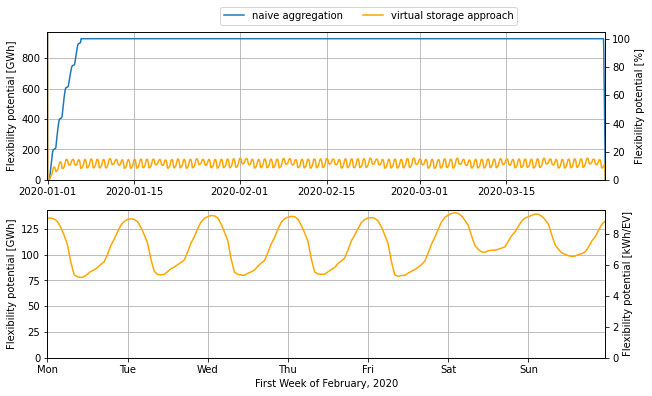

In [ ]:
#add figure with two plots 
fig, ax = plt.subplots(2,1, figsize=(10,6))

#plot 1
ax[0].plot(ts.index, ts[keys[0]], label = keys[0])
ax[0].plot(ts.index, ts[keys[1]], label = keys[1], color = "orange")
ax[0].set_ylabel("Flexibility potential [GWh]")

ax2 = ax[0].twinx()
ax2.plot(ts.index, ts[keys[0]]/ts.max().max()*100, alpha = 0)
ax2.set_ylabel("Flexibility potential [%]")

#plot 2
condition = (ts.index.week > 5)&(ts.index.week < 7)
df = ts[keys[1]][condition]
df_scaled = df/scale/fleet_size

ax[1].plot(df.index, df,  color = "orange")
ax[1].set_ylabel("Flexibility potential [GWh]")

ax3 = ax[1].twinx()
ax3.plot(df_scaled.index, df_scaled, alpha =0)
ax3.set_ylabel("Flexibility potential [kWh/EV]")

#Adjustments
ax[0].legend(loc='upper left', bbox_to_anchor=(0.3, 1.2), ncol=len(keys))


ax[1].xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%a'))

ax[0].grid(), ax[1].grid()
ax[1].set_xlabel("First Week of February, 2020")

ax[0].set_ylim(0), ax[1].set_ylim(0)
ax2.set_ylim(0)
ax[0].set_xlim(ts.index[0],ts.index[-1]), ax[1].set_xlim(df.index[0],df.index[-1])
ax3.set_ylim(0)




plt.savefig('level_comparison_size.pdf', bbox_inches = "tight", dpi=1200)



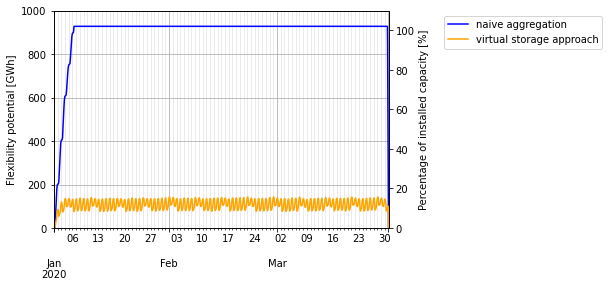

In [ ]:
ax = fig.add_subplot(111)


ax = ts.plot(ylabel="Flexibility potential [GWh]", color = ["blue", "orange"])

#ax.legend(bbox_to_anchor=(0.98,0.2))

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ts_2 = pd.Series(100,level_index)
ax2 = ts_2.plot(alpha=0, ylabel="Percentage of installed capacity [%]")

n = round(ts.loc[ts.index[1:], keys[1]].max())
#ax.axhline(n, color="black", alpha = 1, linewidth=0.8)
#ax.text(y=n+20,x=t[-200], s=f"< {n} GWh,  {round(n/ts.max().max(), 2)*100}%")

ax.set_ylim(0), ax2.set_ylim(0)


ax.grid('on', which='minor', axis='x', alpha=0.3)
ax.grid('on', which='major' )

max_val = 100 - int(overestimated.max()*scale) % 100 + int(overestimated.max()*scale)

ax.legend(bbox_to_anchor=(1.15, 1))


for i, s in enumerate([ts, ts_2]):
    if i == 0: 
        step_size = (max_val)/5 
        ax.set_ylim(0, max_val)
        ax.set_yticks(np.arange(0,max_val+1, step_size))
    else:
        step_size = 100/5
        ax2.set_ylim(0, 110)
        ax2.set_yticks(np.arange(0,109, step_size))

#plt.savefig('level_comparison_size.png', bbox_inches = "tight", dpi=1200)

ts.max().max()/(aggregated_max_battery*scale)

/Users/Jarusch/opt/anaconda3/envs/emobpyenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.


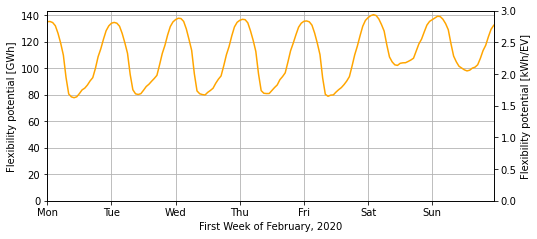

In [ ]:
condition = (ts.index.week > 5)&(ts.index.week < 7)
df = ts[keys[1]][condition]
df_scaled = df/scale/fleet_size

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(df.index, df,  color = "orange")
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

ax.set_ylabel("Flexibility potential [GWh]")
ax.grid('on', which='minor', axis='x', alpha=0.3)
ax.grid('on', which='major' )
ax.set_xlabel("First Week of February, 2020")
ax.set_xlim(df.index[0],df.index[-1])
ax.set_ylim(0)


ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2.set_ylabel("Flexibility potential [kWh/EV]")

ax.set_ylim(0), ax2.set_ylim(0, 3)

#plt.savefig('flex_potential_ees.png', bbox_inches = "tight", dpi=1200)

In [ ]:
#ts_no_level = ts[keys[1]]
#ts_no_charge = ts[keys[1]]
#ts_pub = ts[keys[1]]
#ts_no_pub = ts[keys[1]]
#ts[keys[1]] = ts_pub

#df_all = pd.concat([ts_no_pub, ts_pub], axis=1, keys=["constrained", "unconstrained"])
#df_all.to_pickle("flex_potential_sensitivity.pickle")
df_all = pd.read_pickle("flex_potential_sensitivity.pickle")

/Users/Jarusch/opt/anaconda3/envs/emobpyenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.


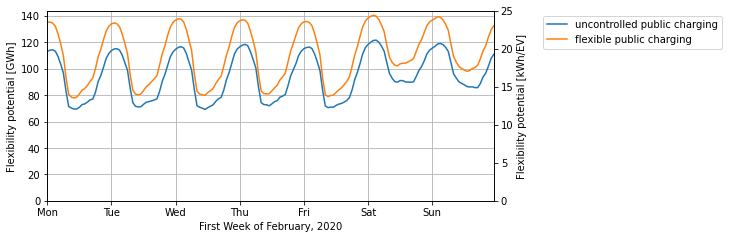

In [ ]:
condition = (df_all.index.week > 5)&(df_all.index.week < 7)
df = df_all[condition]
df_scaled = df/scale/fleet_size

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(df.index, df)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

ax.set_ylabel("Flexibility potential [GWh]")
ax.grid('on', which='minor', axis='x', alpha=0.3)
ax.grid('on', which='major' )
ax.set_xlabel("First Week of February, 2020")
ax.set_xlim(df.index[0],df.index[-1])
ax.set_ylim(0)

ax.legend(df.columns, bbox_to_anchor=(1.1, 1))


ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2.set_ylabel("Flexibility potential [kWh/EV]")

ax.set_ylim(0), ax2.set_ylim(0, 25)

#plt.savefig('flex_potential_ees_sensitivity.png', bbox_inches = "tight", dpi=1200)

In [ ]:
#df_all_soc = pd.concat([ts_0, ts_10, ts_20], axis = 1, keys=["0%", "10%", "20%"])
#df_all_soc.to_pickle("minimal_avoid_level_sensitivity")
df_all_soc = pd.read_pickle("minimal_avoid_level_sensitivity")

/Users/Jarusch/opt/anaconda3/envs/emobpyenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.


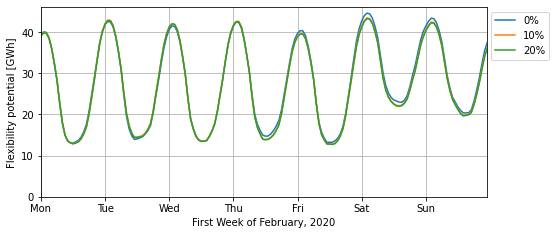

In [ ]:

condition = (df_all_soc.index.week > 5)&(df_all_soc.index.week < 7)
df = df_all_soc[condition]

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.plot(df.index, df)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))

ax.set_ylabel("Flexibility potential [GWh]")
ax.grid('on', which='minor', axis='x', alpha=0.3)
ax.grid('on', which='major' )
ax.set_xlabel("First Week of February, 2020")
ax.set_xlim(df.index[0],df.index[-1])
ax.set_ylim(0)

ax.legend(df.columns, bbox_to_anchor=(1.15, 1))


ax.set_ylim(0)

#plt.savefig('avoid_min_level_sensitivity.png', bbox_inches = "tight", dpi=1200)

## Aggregated Optimization with exogenous prices, not part of the paper

Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

#!pip install pickle5
import pickle5 as pickle
with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)


price_mode = "real_price"
prices = data
 
prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

ax = (prices*1000).plot(ylabel="el. price [€/MWh]")

ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major')

#plt.savefig(os.path.join(pics, 'prices.png'), bbox_inches = "tight")


agg_solutions = {}

for model_type in ["naive", "ees"]: 

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
        m_agg.uncontrolled_charge = pyo.Param(m_agg.t, initialize=uncontrolled_charge_accurate.to_dict()) 
        
        #recursive level
        def recursive_level(m_agg, t):
            if t == level_index[0]:
                print(t)
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])*step_duration   
            else:
                
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(f'{step_duration} H')] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
            
    else:
        def final_level(m_agg, t):
            if t == index[-1]:
                return m_agg.LEVEL[t] == level_T_agg
            else: 
                return pyo.Constraint.Skip
        m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
        
        def recursive_level(m_agg, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(f'{step_duration} H')] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration 
            
       
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def level_constraint(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= 0
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    #if (model_type == "naive")  & (flex=="constrained"): ####
     #   dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
      #  m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)

      #  def full_before_next_trip(m_agg, t_dep):
       #     return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        #m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
                    
    def power_discharge_phys_max(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
        else: 
            return m_agg.DISCHARGE_PHYS[t] == 0
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    if model_type == "ees":
        def power_charge_max(m_agg, t):
            return m_agg.CHARGE[t] <= m_agg.power[t] - m_agg.uncontrolled_charge[t] 
        
        def power_discharge_consumption_max(m_agg, t):
                return m_agg.DISCHARGE_WAIT[t] <=  m_agg.uncontrolled_charge[t] 
        m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    else:
        def power_charge_max(m_agg, t):
            return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)
    
    # objective function
    if model_type == "ees":
        def min_ees_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t] - m_agg.DISCHARGE_PHYS[t]) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    if model_type == "ees":
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    else:
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

#costs
fig, ax = plt.subplots()

plt.bar(x = ["uncontrolled", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

fig.tight_layout()
#plt.savefig(os.path.join(pics, price_mode,'costs.pdf'),  bbox_inches = "tight") 